In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls
from statsmodels.formula.api import mixedlm
from patsy.contrasts import Treatment

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(1024)

In [2]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'

In [3]:
smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non_smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi_numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight']

vols_feat = ['seg_liver', 'seg_spleen']
spleen_sample_cols = ['0_spleen','1_spleen','2_spleen','3_spleen','4_spleen','5_spleen','6_spleen','7_spleen','8_spleen','9_spleen']
liver_sample_cols = ['0_liver','1_liver','2_liver','3_liver','4_liver','5_liver','6_liver','7_liver','8_liver','9_liver']

feats_from_paper_for_group_test = [['age', 'sex_0', 'sex_1', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['cholesterol_hdl', 'cholesterol_ldl'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular']]

feats_from_paper_for_individual_test = [['age', 'sex_0', 'sex_1', 'bmi_numeric'],
             ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['hypertension'], ['triglyceride'],
             ['blood_pressure_diastolic', 'blood_pressure_systolic'],
             ['cholesterol_hdl', 'cholesterol_ldl', 'cholesterol_total'],
             ['mri_liver_fat_artifacts', 'mri_liver_fat_lobus_dexter', 
              'mri_liver_fat_lobus_sinister', 'mri_liver_fat_portal_vein'],
             ['meds_lipoprotein_lowering', 'meds_antihypertensive'],
             ['smoker_former', 'smoker_non_smoker', 'smoker_regular'], ['alcohol_g_day']]

paper_link = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0177154&type=printable'

In [4]:
model_merged_feats_path = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'}
]
all_dataset_merged_feats_path = [
    {'all_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_False_concat_report_final.csv'}, 
    {'all_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'}
]

test_dataset_merged_feats_path = [
    {'test_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_False_concat_report_final.csv'}, 
    {'test_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_True_concat_report_final.csv'}
]

all_paths = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'},
    {'all_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_False_concat_report_final.csv'}, 
    {'all_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'},
    {'test_KORA_processed_False': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_False_concat_report_final.csv'}, 
    {'test_KORA_processed_True': '/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/test_processed_True_concat_report_final.csv'}
]

final_model_report_path = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_final_report.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_final_report.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_final_report.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_final_report.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_final_report.csv'}
]

fb = 'full_bayesian'
fb01 = 'full_bayesian_0dot01'
mc = 'MC_dropout_quicknat'
pq = 'probabilistic_quicknat'
hq = 'hierarchical_quicknat'
af = 'all_KORA_processed_False'
at = 'all_KORA_processed_True'
tf = 'test_KORA_processed_False'
tt = 'test_KORA_processed_True'

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]

def transform_to_categorical(df, categorical_features_list):
    for f in categorical_features_list:
        dfDummies = pd.get_dummies(df[f], prefix = f)
        df = pd.concat([df, dfDummies], axis=1)
    return df

def rename(df, cols_map=None):
    if cols_map is None:
        cols_map =  {'bmi-numeric':'bmi_numeric', 'blood-pressure-diastolic':'blood_pressure_diastolic', 'blood-pressure-systolic':'blood_pressure_systolic',
             'cholesterol-hdl':'cholesterol_hdl', 'cholesterol-ldl':'cholesterol_ldl', 'cholesterol-total':'cholesterol_total',
             'mri-liver-fat-artifacts':'mri_liver_fat_artifacts', 'mri-liver-fat-lobus-dexter':'mri_liver_fat_lobus_dexter', 
              'mri-liver-fat-lobus-sinister':'mri_liver_fat_lobus_sinister', 'mri-liver-fat-portal-vein':'mri_liver_fat_portal_vein',
             'meds-lipoprotein-lowering':'meds_lipoprotein_lowering', 'meds-antihypertensive':'meds_antihypertensive',
              'smoker_non-smoker':'smoker_non_smoker','alcohol-g/day':'alcohol_g_day'}
    df.rename(columns=cols_map, inplace=True)
    return df

def z_score_column_normalise(df, column_list):
    normalised_cols_map = {}
    for column in column_list:
        normalised_cols_map[column] = column+'_normalised'
        df[normalised_cols_map[column]] = (df[column] - df[column].mean())/df[column].std(ddof=0)
    return df, normalised_cols_map

def z_score_group_normalise(df, cols_to_normalise):
    normalised_cols_map = {}
    group_cols_value = df[cols_to_normalise].values
    mean, std = np.mean(group_cols_value), np.std(group_cols_value, ddof=0)
    for column in cols_to_normalise:
        normalised_cols_map[column] = column+'_normalised'
        df[normalised_cols_map[column]] = (df[column] - mean)/std
    return df, normalised_cols_map

def pre_process_for_mlm(df, to_be_transpose_cols, value_name):
    cols = list(df.columns)
    cols_without_tobe_transposed_cols = list(set(cols) - set(to_be_transpose_cols))
    df = df.melt(id_vars=cols_without_tobe_transposed_cols, 
            value_vars=to_be_transpose_cols, 
            value_name=value_name)

    return df

In [6]:
def split_diabetes_state(df):
    df_normal = df[df['diabetes_status']==0]
    df_pre_diabetic = df[df['diabetes_status']==1]
    df_diabetic = df[df['diabetes_status']==2]
    df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
    df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
    df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
    dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])
    return dfs

def plot_and_ttest(df, cols):
    dicts = {}
    for col_subset in itertools.combinations(cols, 2):
        print(f'{col_subset[0]} vs {col_subset[1]}')
        df[list(col_subset)].boxplot(rot=45)
        t,p = stats.ttest_ind(df[col_subset[0]].dropna().values, df[col_subset[1]].dropna().values)

        print('ttest_score:', t)
        print('p_value:', p)
        print('\n')
        dicts[f'{col_subset[0]} vs {col_subset[1]}'] = p
        plt.show()
    return dicts

In [7]:
def model_evaluation_matrics(file_paths_dict, cols_to_fetch):
    dicts = {}
    for model, path in file_paths_dict.items():
        df = pd.read_csv(path)
        dicts[model] = df[cols_to_fetch].iloc[1].values
    return dicts

In [8]:
def individual_feature_stats(feats, df, target_col):
    p_values = []
    y = df[target_col].copy()
    y_classes = y.values
    for f in feats:
        try:
            X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
            mod = sm.OLS(y_classes, X)
            fii = mod.fit()
#             is_significant = True if fii.pvalues.values[0] < 0.05 else False
            p_values.append(fii.pvalues.values[0])
        except Exception as e:
            print(e)

    return p_values

In [9]:
from patsy.contrasts import Treatment
significance_check = lambda x: False if x>0.05 else True
def group_feature_stats(feats, df, target_col):
    p_values, fii = None, None
    y = df[target_col].copy()
    y_classes = y.values
    try:
        X = pd.get_dummies(df.loc[y.index, feats], drop_first=True)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#         print(fii.pvalues.values[0], fii.params.values)
#         is_significant_list = [significance_check(p_value) for p_value in fii.pvalues.values]   
        p_values = fii.pvalues.values
    except Exception as e:
        print(e)
        
    return p_values, fii


In [17]:


def normal_group_fit(df, target_col, features_string):
    model = ols(f'{target_col} ~ {features_string}', df).fit()
    plot_model_outputs(df['bmi_numeric'].values, df[target_col].values, model, 'OLS')
    return model

def weighted_group_feats(df, target_col, features_string, alpha_col):
    alpha = df[alpha_col].values
    model = wls(f'{target_col} ~ {features_string}', df, weights=alpha).fit()
    df_ = df.sort_values('diabetes_status')
    plot_model_outputs(df_['diabetes_status'].values, df_[target_col].values, model, 'WLS', df_)
    model = ols(f'{target_col} ~ {features_string}', df).fit()
    plot_model_outputs(df_['diabetes_status'].values, df_[target_col].values, model, 'OLS', df_)
#     model = ols(f'{target_col} ~ {features_string}', df).fit_regularized(alpha=alpha, L1_wt=L1_wt)
    return model

def normal_mixed_effect_model(df, target_col, features_string, group_col, L1_wt=None):
    if L1_wt is None:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit()
    else:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit_regularized(L1_wt=L1_wt)
    return model

def anova_test(ols_model):
    anova_stats = sm.stats.anova_lm(ols_model)
    return anova_stats

In [11]:
def gathering_p_values():
    pass

In [12]:
def df_from_nested_dicts(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv).T}, axis=0) for k, v in dicts.items() for kk, vv in v.items()}, axis=0)
    return df

def df_from_nested_dicts_group(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv).T}, axis=0) for k, v in dicts.items() for kk, vv in v.items()}, axis=0)
    return df

def highlight_significance(df):
    return df.style.applymap(lambda x: 'background-color : yellow' if x==True or x<0.05 else '')

In [13]:
model_merged_feats_path_combined = {key:val for d in all_paths for key,val in d.items()}
only_models_final_report_path = {key:val for d in final_model_report_path for key,val in d.items()}

# Model Evaluations

In [14]:
cols_to_fetch = ['sncc', 'ged', 'iou_spleen', 'iou_liver', 'dice_spleen',
       'dice_liver', 'surface_distance_avg_spleen', 'surface_distance_avg_liver']
dicts = model_evaluation_matrics(only_models_final_report_path, cols_to_fetch)
df_model_eval = pd.DataFrame.from_dict(dicts)
df_model_eval = df_model_eval.T
df_model_eval.columns = cols_to_fetch
df_model_eval

,sncc,ged,iou_spleen,iou_liver,dice_spleen,dice_liver,surface_distance_avg_spleen,surface_distance_avg_liver
full_bayesian,0.604205,0.223997,0.524697,0.668660,0.828703,0.894704,0.809946,0.736798
full_bayesian_0dot01,0.439956,0.195701,0.778342,0.843610,0.876280,0.921408,0.878530,0.817305
MC_dropout_quicknat,0.399954,0.166135,0.821329,0.878295,0.897294,0.937717,0.915982,0.870747
probabilistic_quicknat,0.163864,0.228308,0.988114,0.992439,0.873666,0.925428,0.875153,0.827462
hierarchical_quicknat,0.187984,0.209171,0.983818,0.988998,0.883146,0.932802,0.897351,0.854833


# Individual feats stats test

In [ ]:
feats = flatten(feats_from_paper_for_individual_test)

dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    p_value_dict = individual_feature_stats(feats, df, target_col)
    dicts[key][target_col] = p_value_dict
    
    target_col = 'seg_liver_normalised'
    p_value_dict = individual_feature_stats(feats, df, target_col)
    dicts[key][target_col] = p_value_dict

p_value_df = df_from_nested_dicts(dicts)
p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
p_value_df_styler

# Group feats stats test

In [ ]:
feats = flatten(feats_from_paper_for_group_test)

dicts = {}
# anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
#     anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
    target_col = 'seg_liver_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
p_value_df = df_from_nested_dicts(dicts)
# anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
p_value_df.columns = feats
# anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
# anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

In [ ]:
feats = flatten(feats_from_paper_for_group_test)

dicts = {}
# anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
#     anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
    target_col = 'seg_liver_normalised'
    p_value_dict, model = group_feature_stats(feats, df, target_col)
#     result = anova_test(model)
    dicts[key][target_col] = p_value_dict
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]
    
p_value_df = df_from_nested_dicts(dicts)
# anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
p_value_df.columns = feats
# anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
# anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

In [26]:
import seaborn as sns
sns.set(style="whitegrid")
def plot_model_outputs(x, y, model_res, model_label='OLS', df=None):
#     prstd, iv_l, iv_u = wls_prediction_std(model_res)
#     x = np.arange(len(y))
    
    fig, ax = plt.subplots(figsize=(18,16))
#     ax.plot(x, y, 'o-', label="True")

#     ax.plot(x, model_res.fittedvalues, 'o-', label=model_label)
#     ax.plot(x, iv_u, 'r--')
#     ax.plot(x, iv_l, 'r--')
#     ax.legend(loc="best");
    
    ax = sns.violinplot(x="diabetes_status", y=model_res.fittedvalues,
                   data=df, palette="Set2", split=True,
                   scale="count", inner="quartile")
    plt.show()
    
#     fig, ax = plt.subplots(figsize=(8,6))
#     fig = sm.graphics.influence_plot(model, ax=ax)
#     plt.show()

# Regularised group feat stats test

full_bayesian


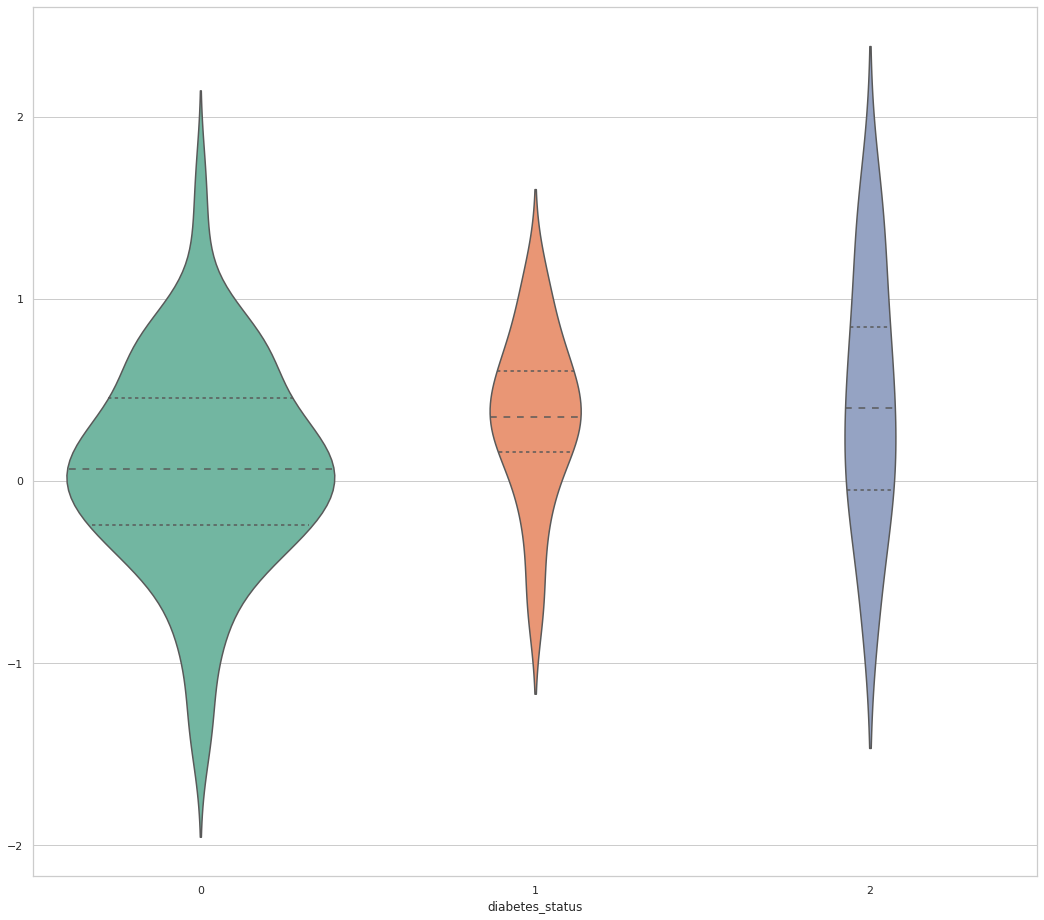

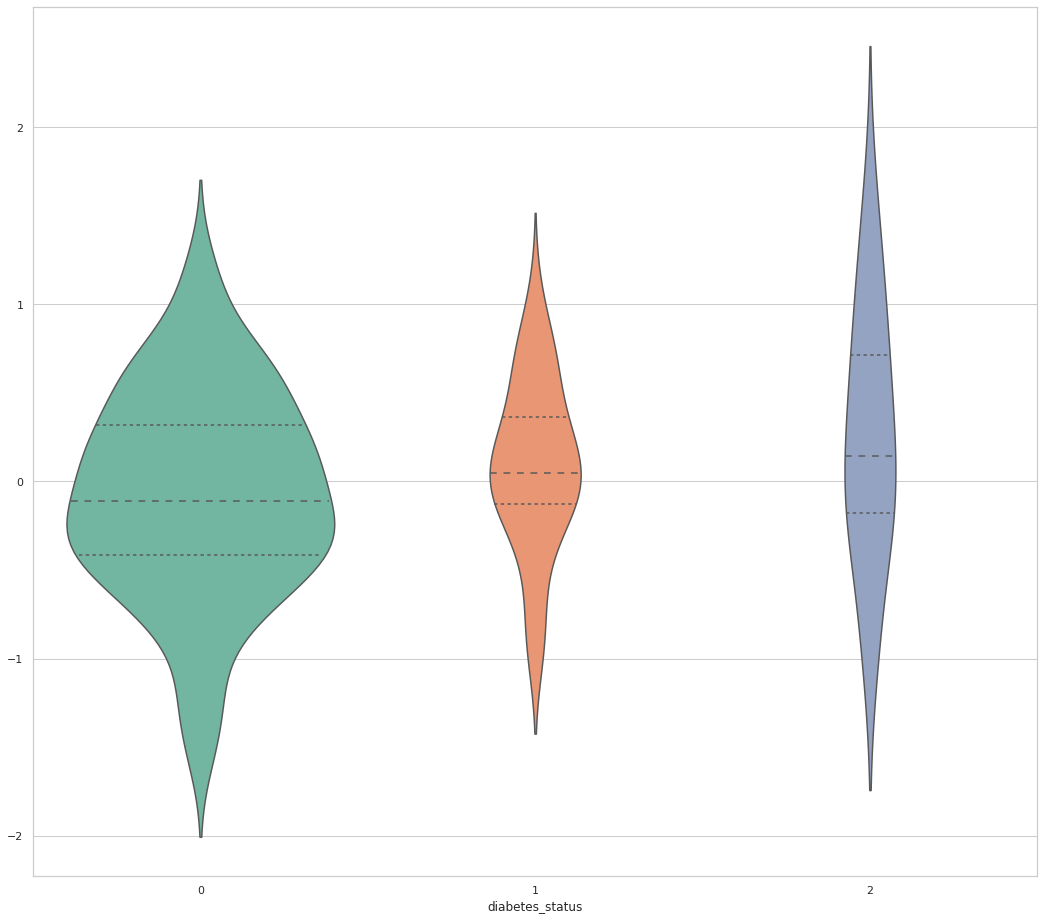

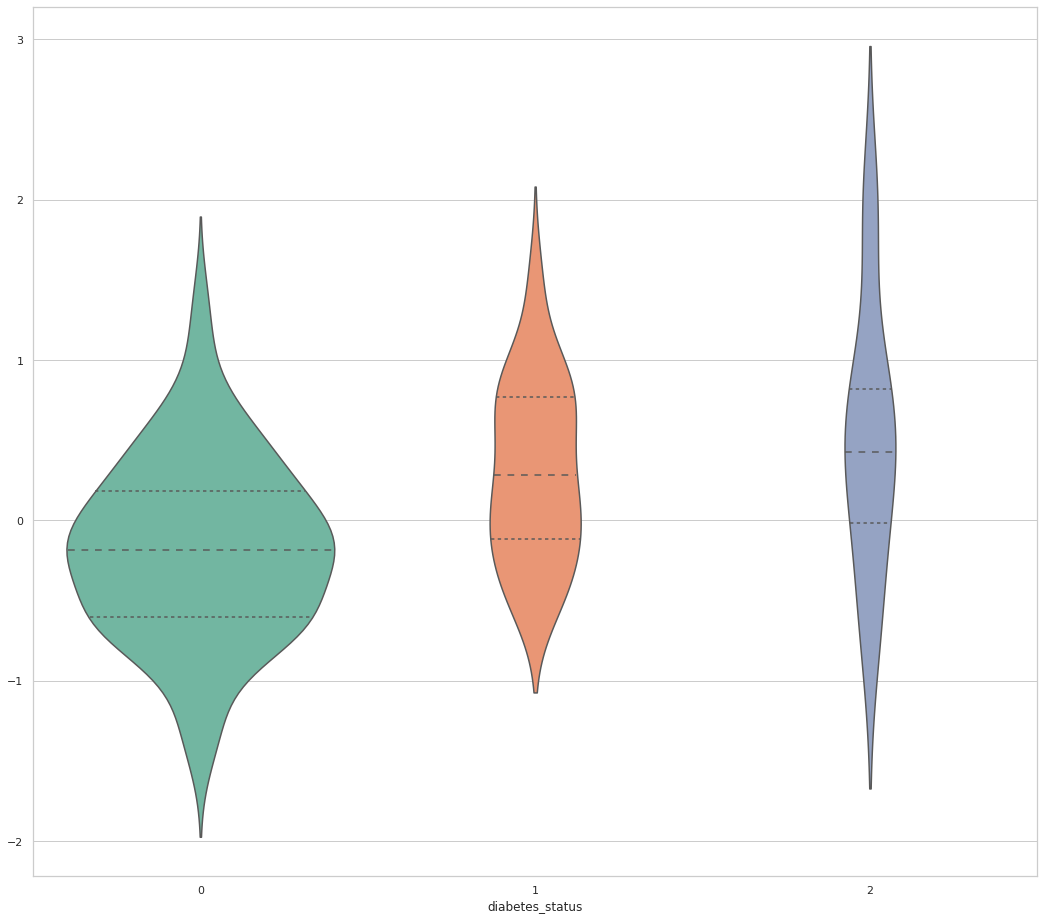

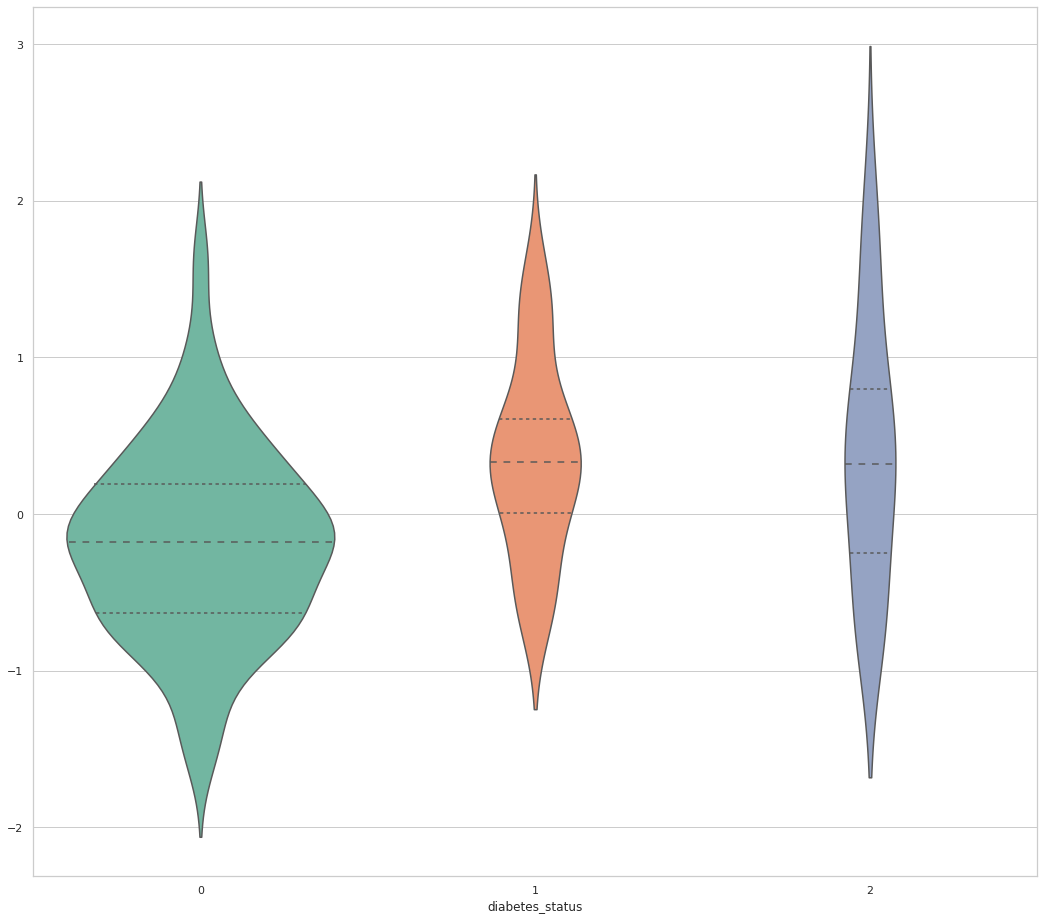

full_bayesian_0dot01


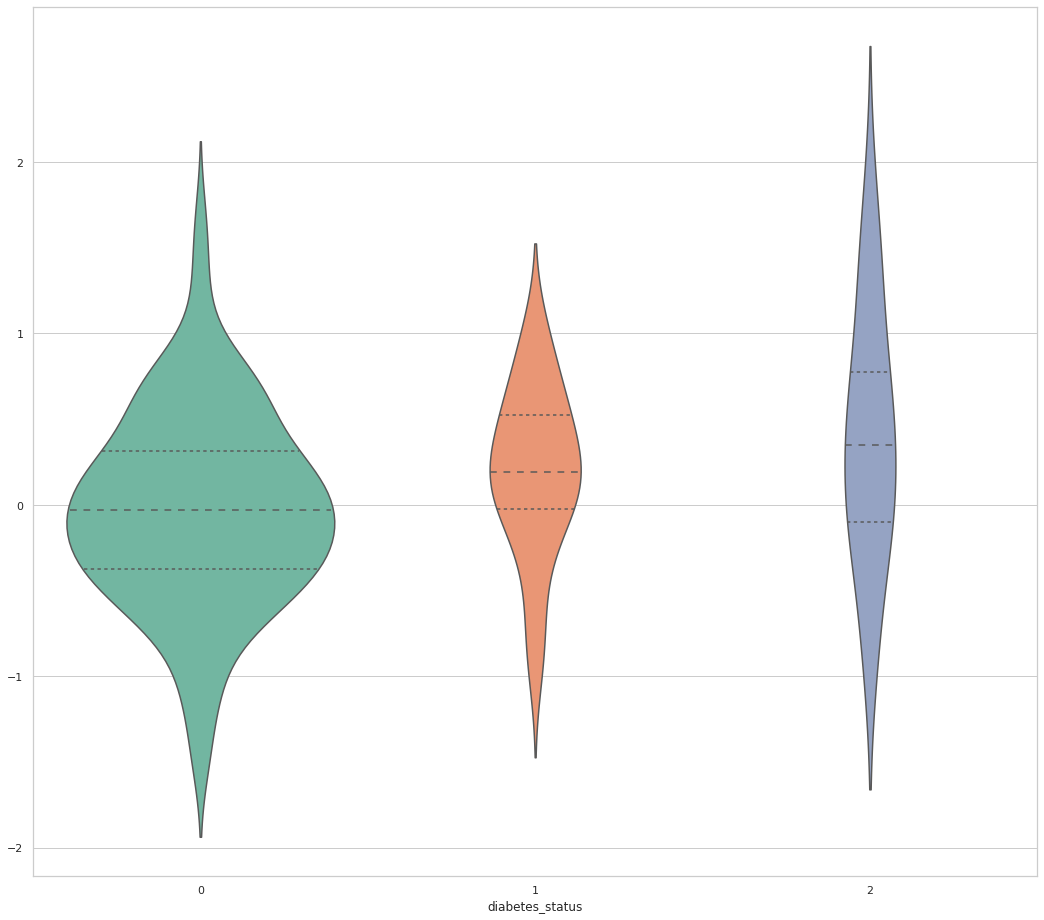

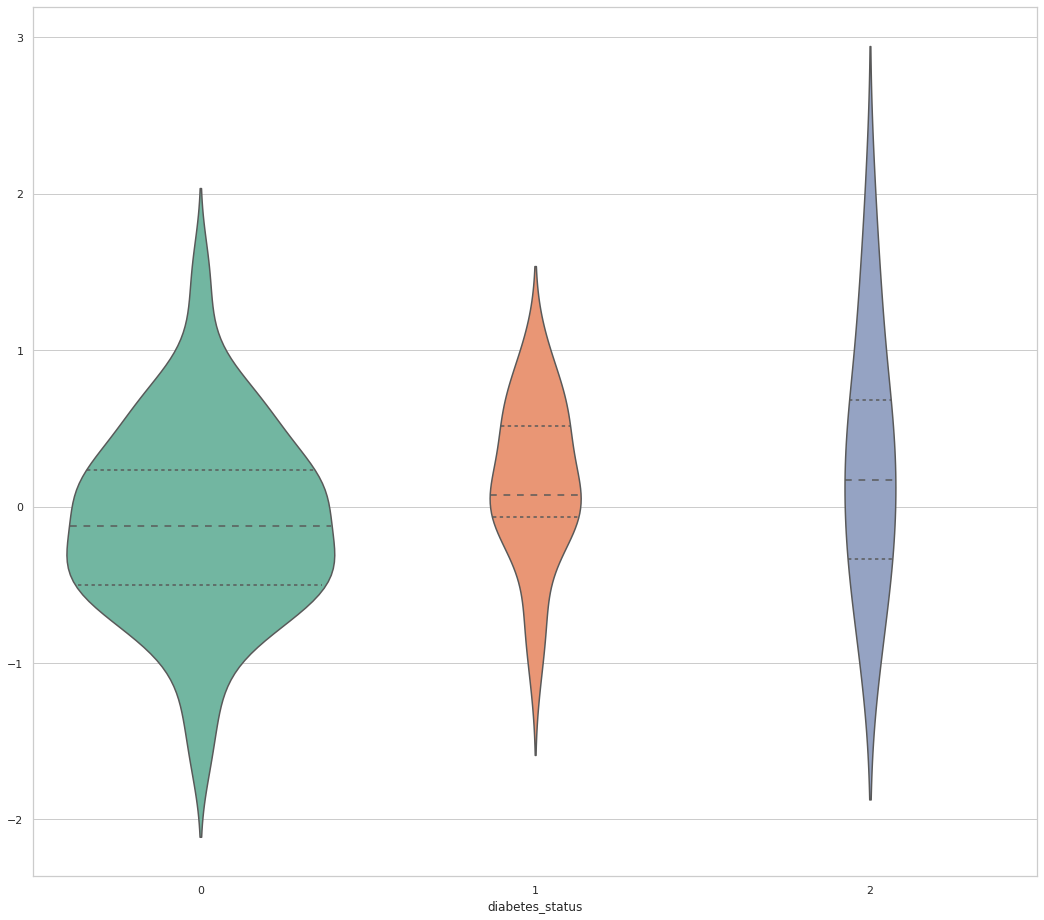

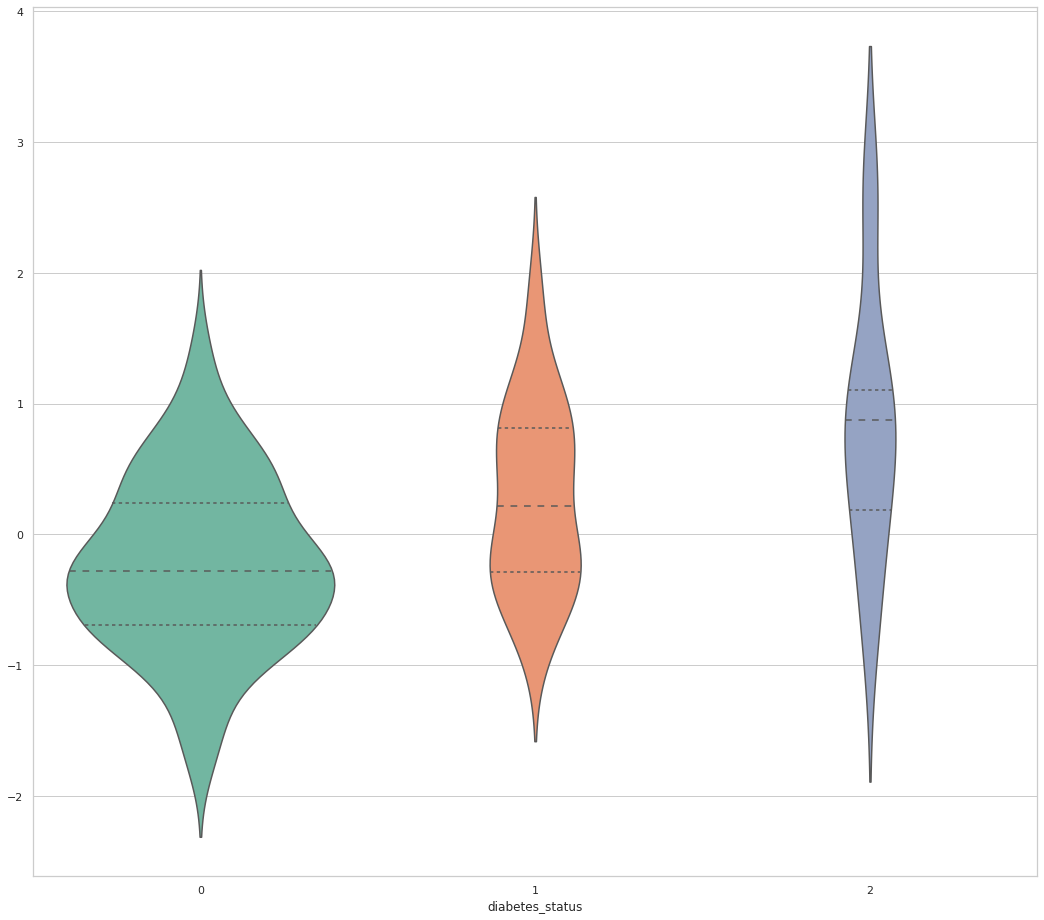

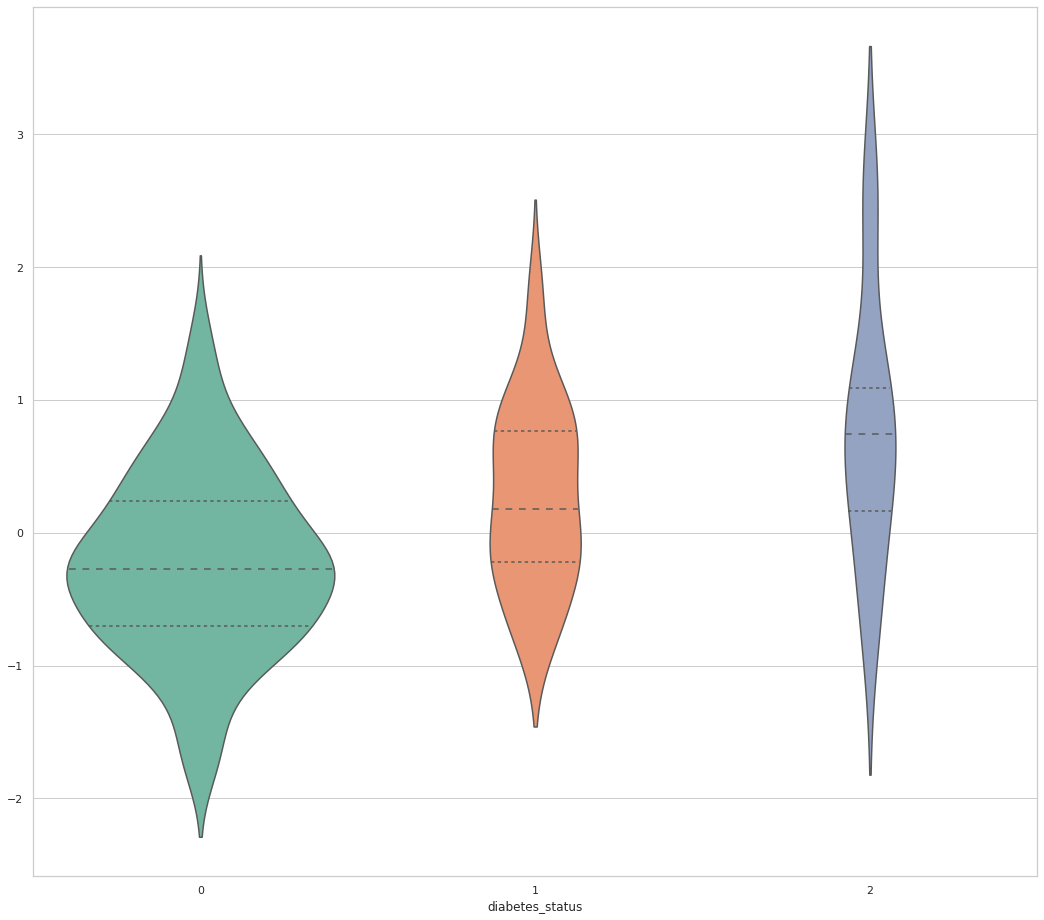

MC_dropout_quicknat


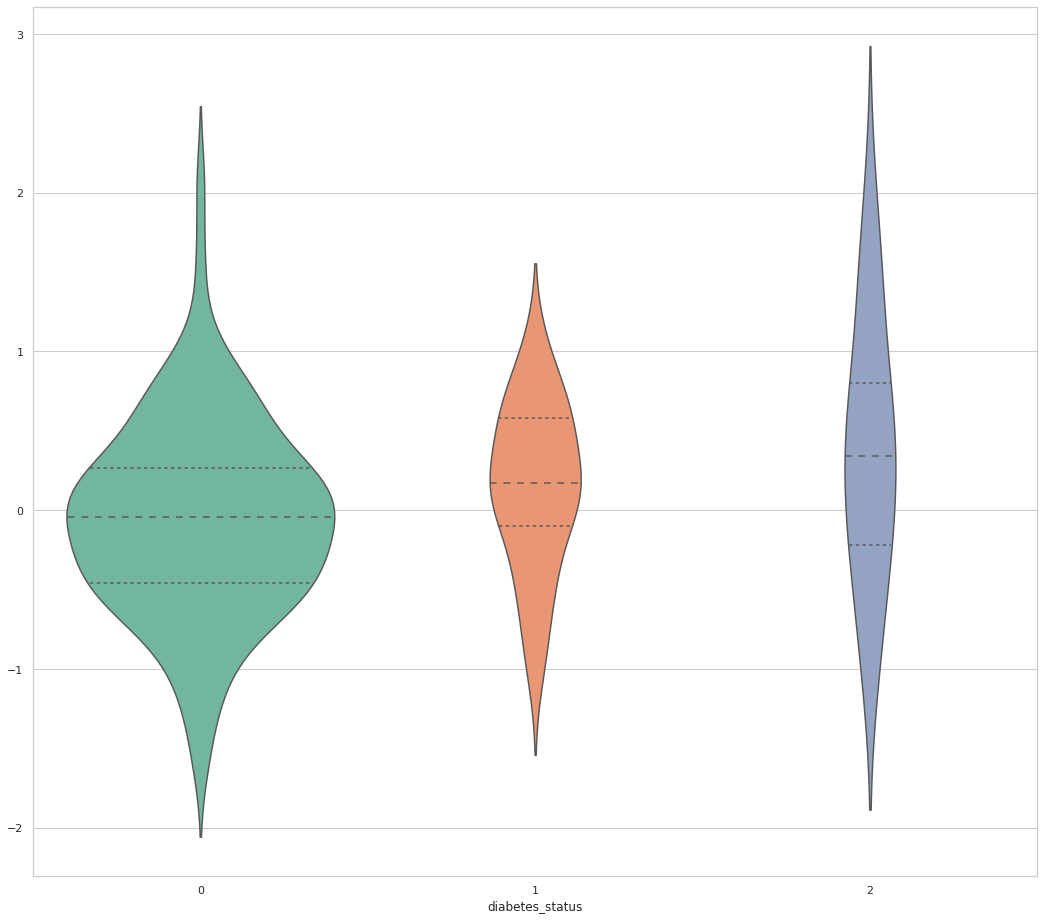

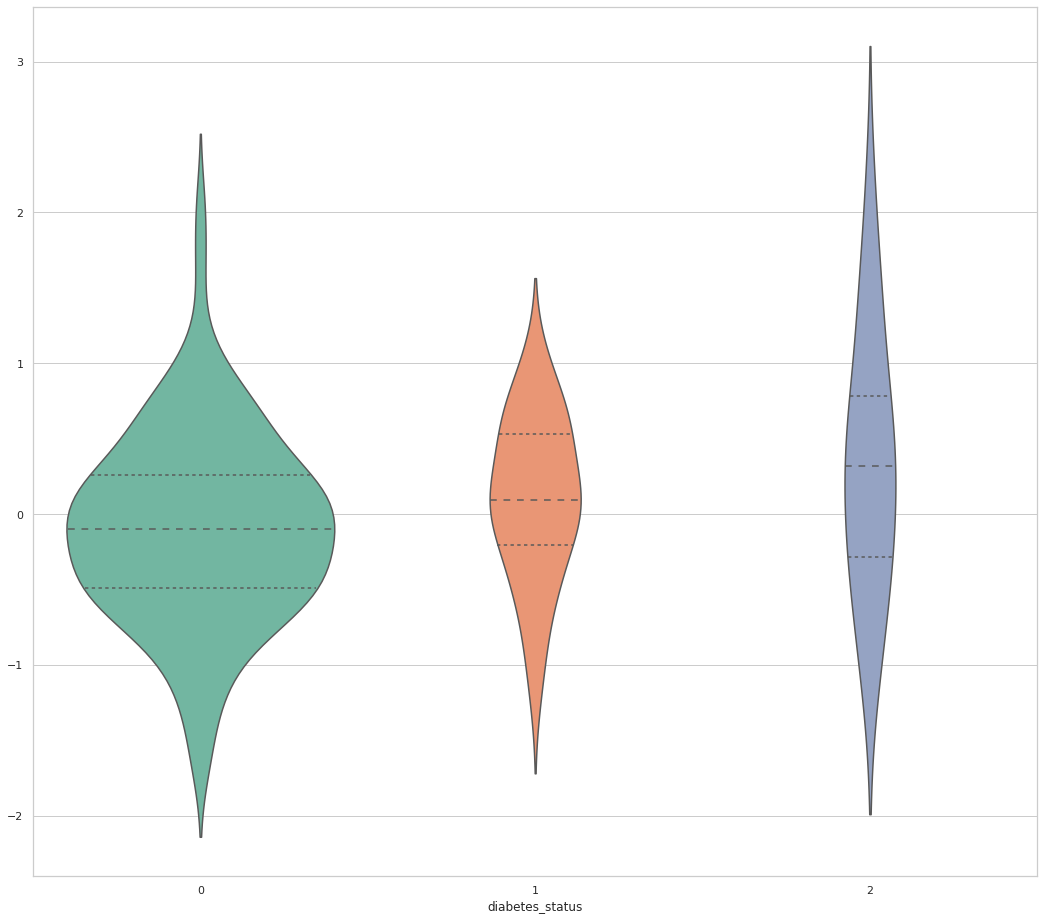

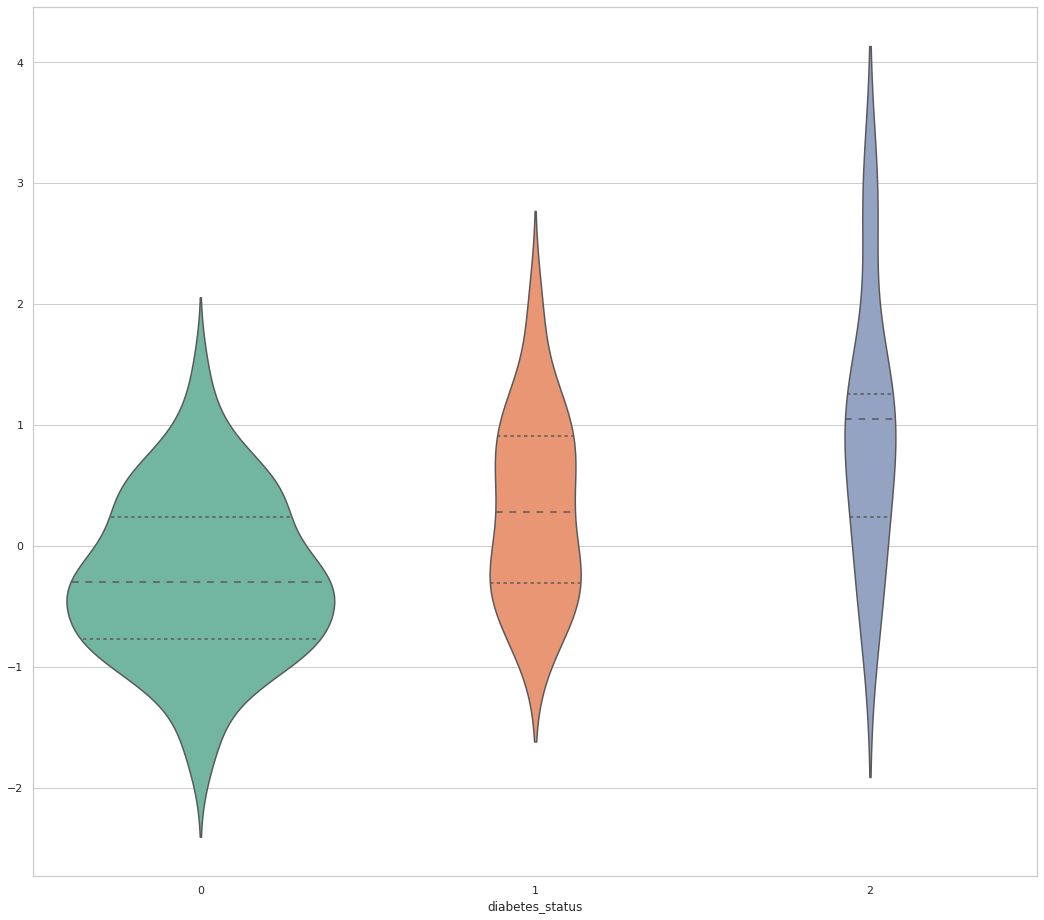

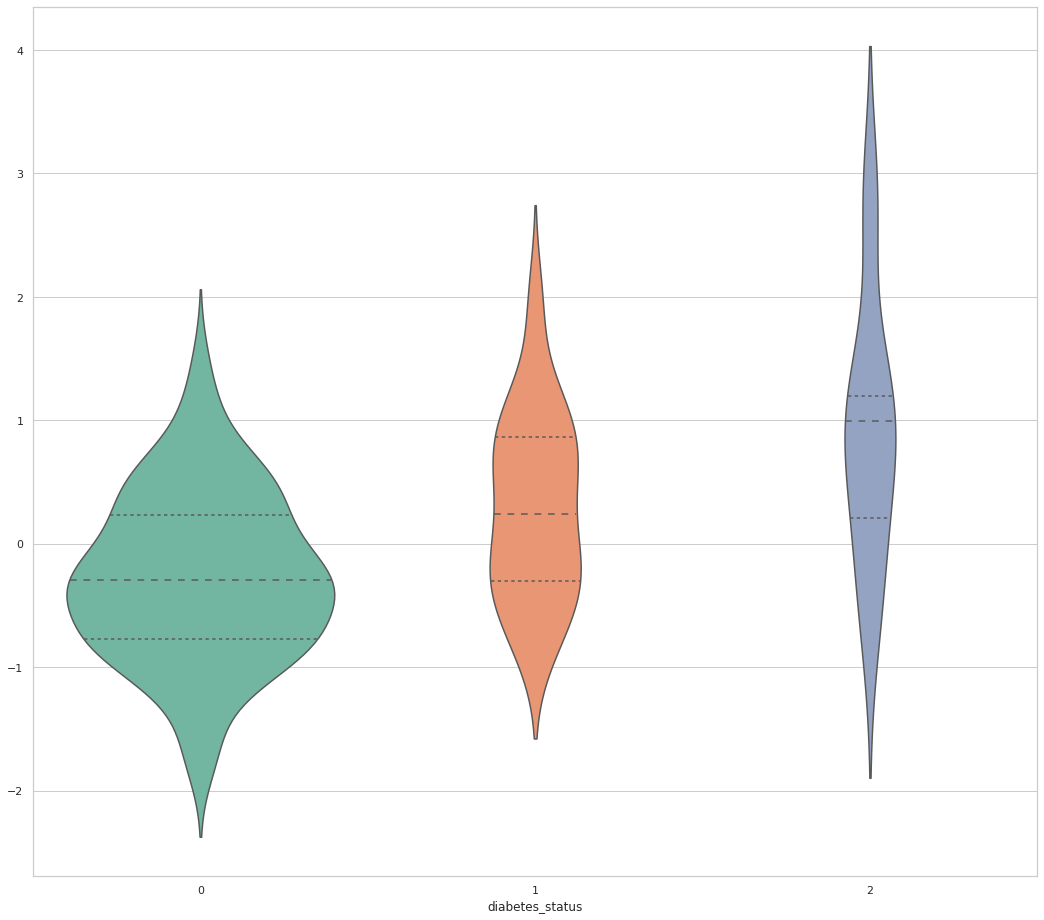

probabilistic_quicknat


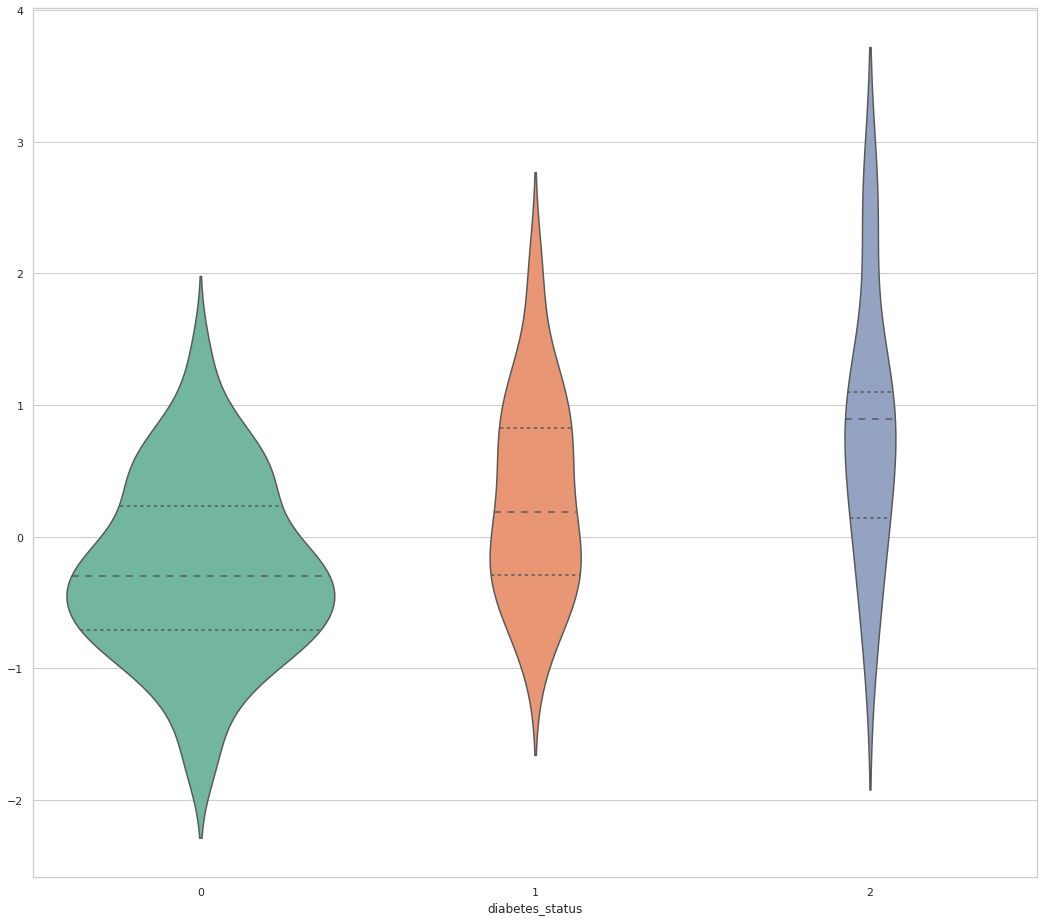

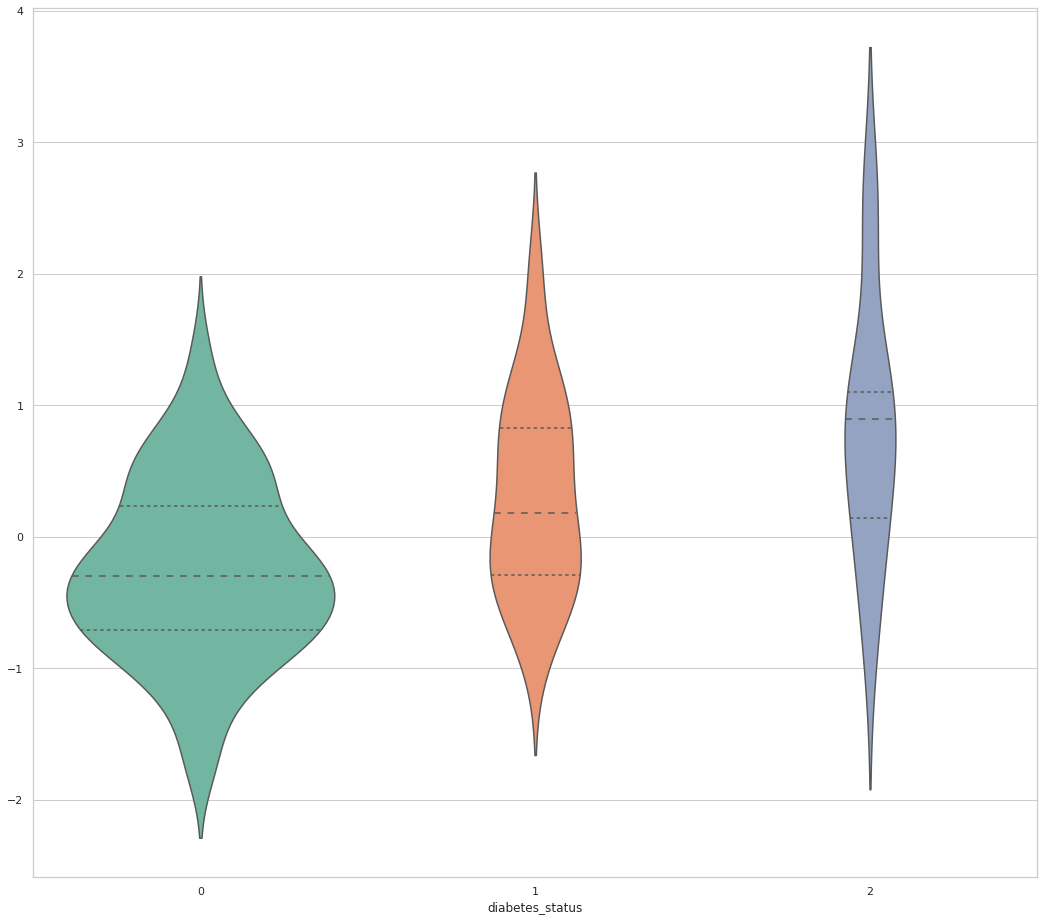

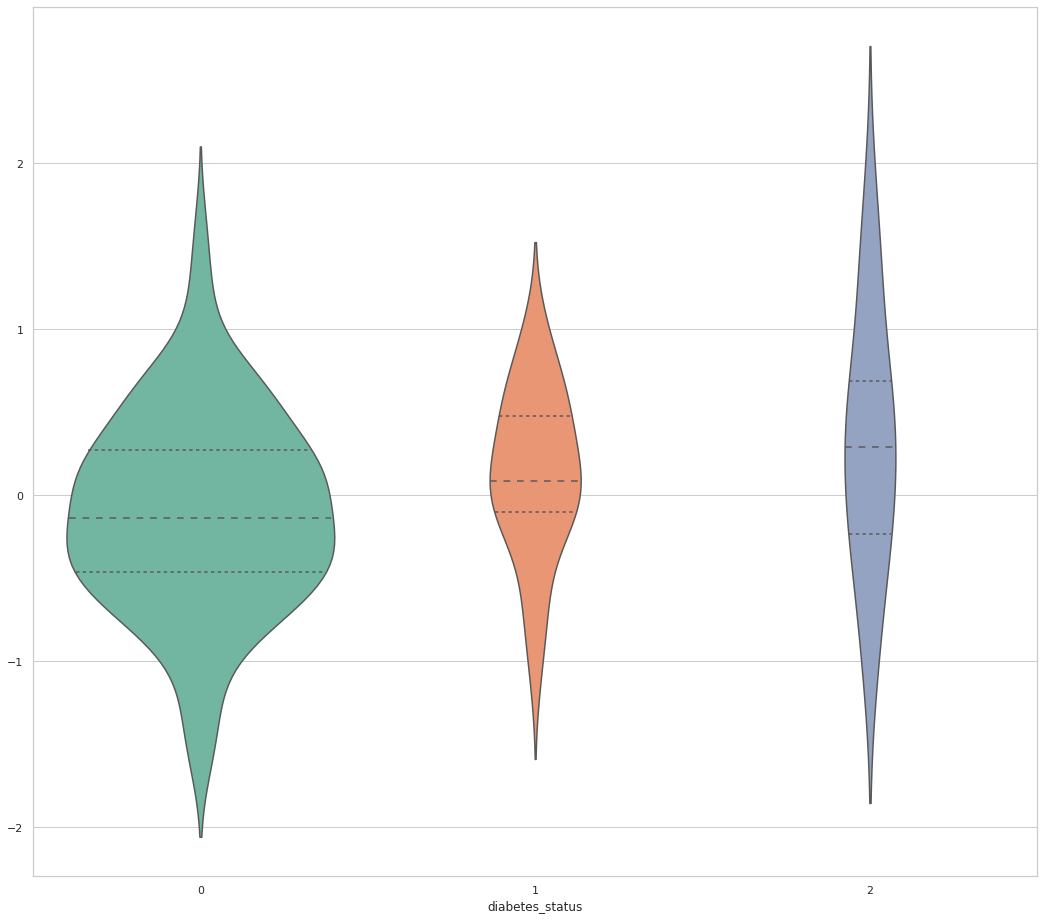

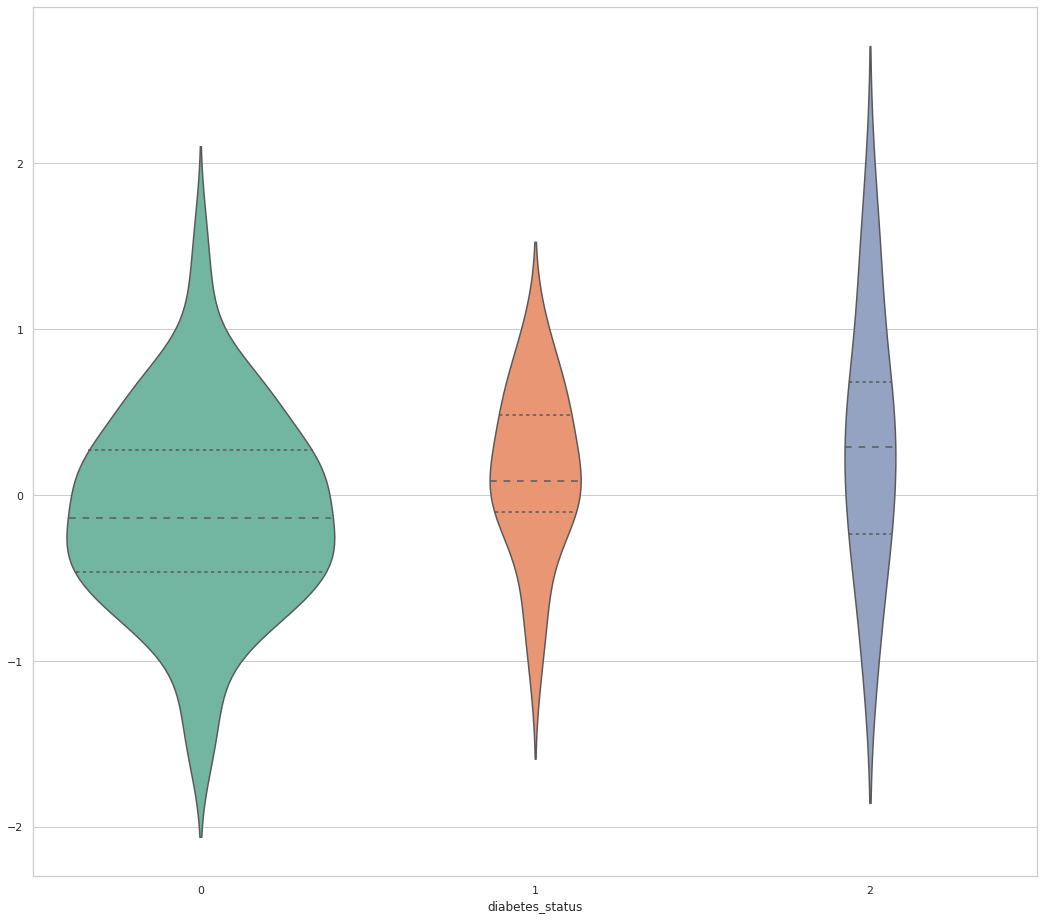

hierarchical_quicknat


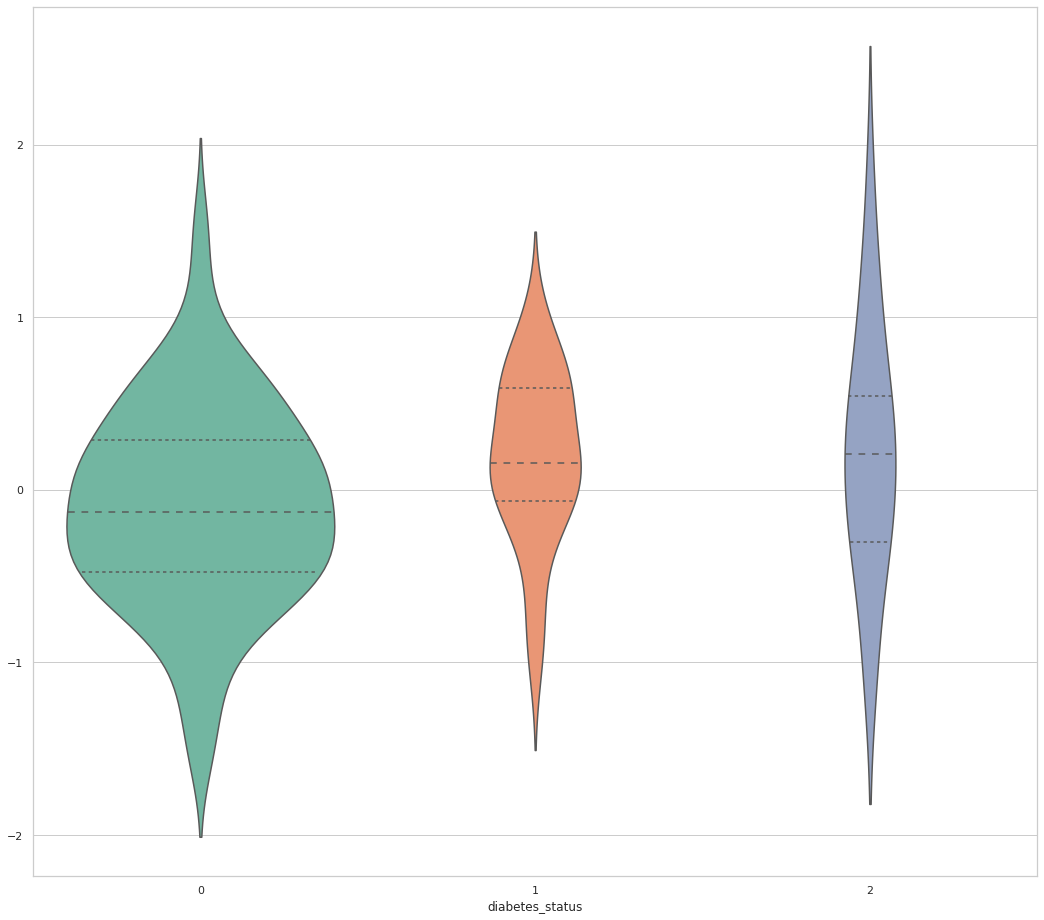

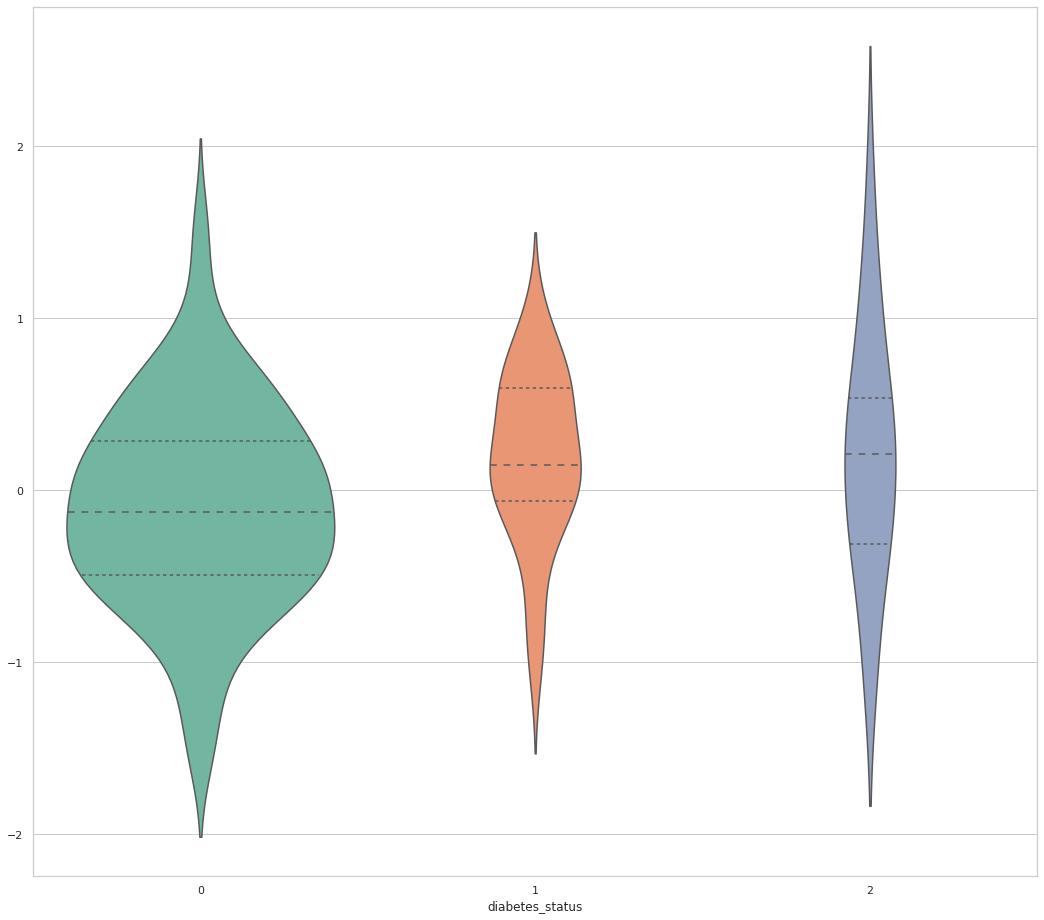

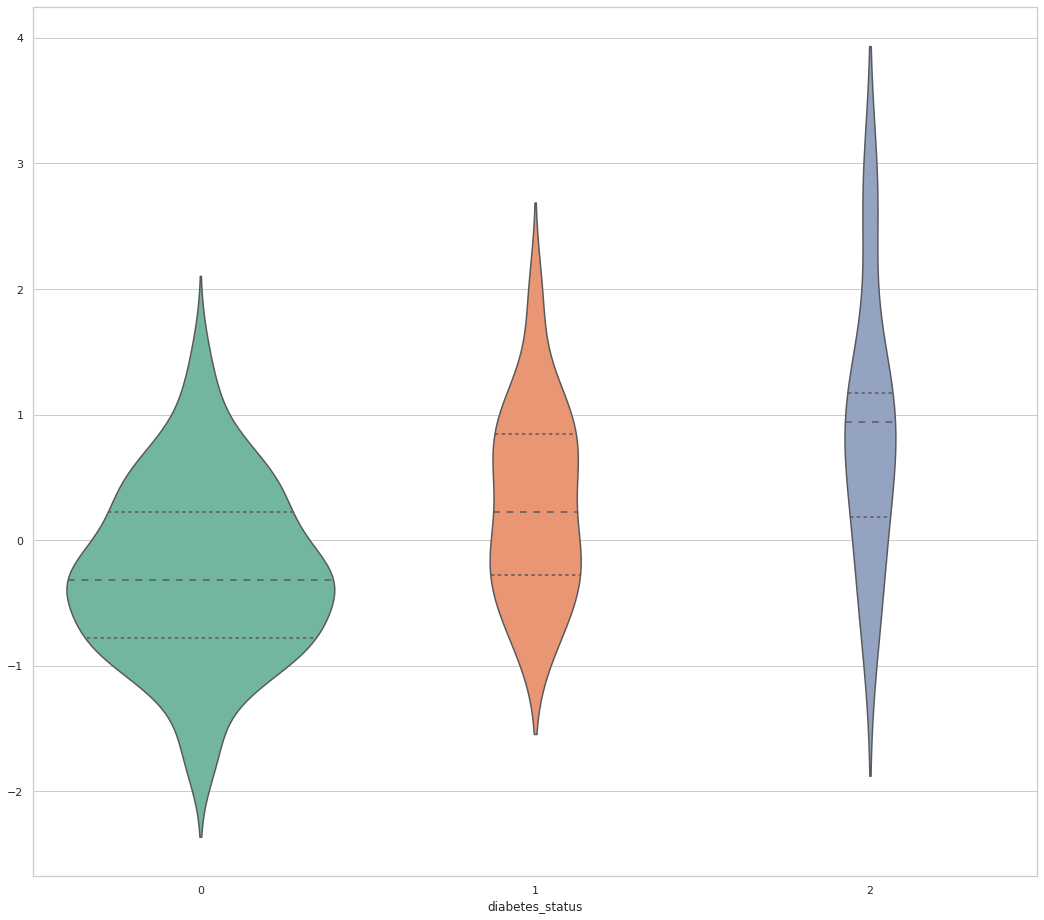

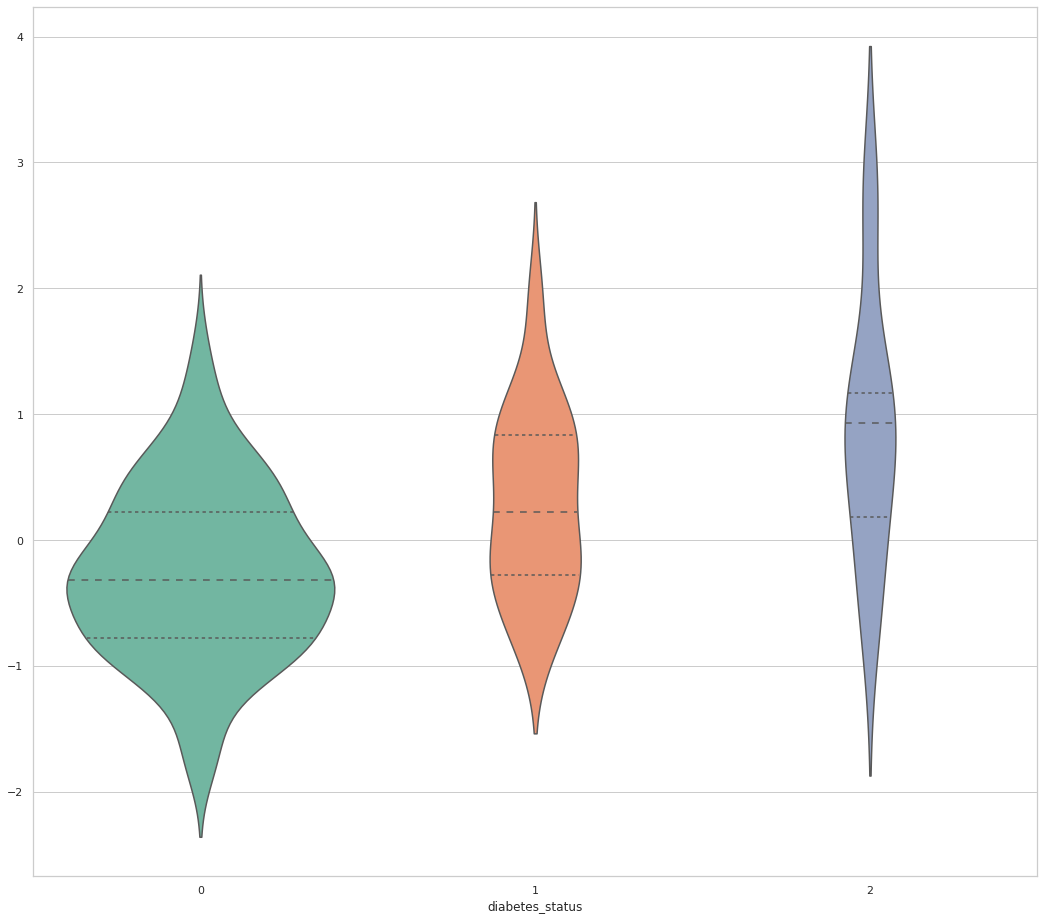

dataset cannot be processed!
dataset cannot be processed!
dataset cannot be processed!
dataset cannot be processed!


,,,age,sex_0,sex_1,bmi_numeric,diabetes_status_0,diabetes_status_1,diabetes_status_2,hypertension,triglyceride,cholesterol_hdl,cholesterol_ldl,mri_liver_fat_artifacts,mri_liver_fat_lobus_dexter,mri_liver_fat_lobus_sinister,mri_liver_fat_portal_vein,meds_lipoprotein_lowering,smoker_former,smoker_non_smoker,smoker_regular
full_bayesian_seg_spleen_normalised,seg_spleen_normalised,0,0.241355,0.0647854,0.902824,0.0287104,0.026244,0.365551,0.691918,0.195343,0.487402,0.266613,0.127042,0.0826758,0.0359392,0.475367,0.806464,0.0702258,0.0900084,0.687214,0.604564
full_bayesian_seg_liver_normalised,seg_liver_normalised,0,0.956659,0.000625486,0.644834,0.540135,2.05807e-06,0.611643,0.55038,0.950022,0.0909036,0.0377272,0.148143,0.0415533,0.687775,0.557751,0.385804,0.643066,0.465348,0.393194,0.507885
full_bayesian_0dot01_seg_spleen_normalised,seg_spleen_normalised,0,0.41061,0.0371062,0.882079,0.0729198,0.000504801,0.781418,0.800798,0.230407,0.717345,0.281175,0.0826453,0.0303325,0.730056,0.242432,0.805263,0.0463051,0.0389965,0.527082,0.931725
full_bayesian_0dot01_seg_liver_normalised,seg_liver_normalised,0,0.315757,2.37526e-06,0.986937,0.0448851,2.5174e-06,0.604929,0.635279,0.239378,0.0701647,0.00605045,0.0626653,0.00108168,0.455683,0.65293,0.643712,0.100784,0.238666,0.355137,0.717375
MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.870638,0.200947,0.251821,0.351685,6.09652e-06,0.770417,0.380351,0.482233,0.919126,0.393165,0.146455,0.00818885,0.742281,0.345656,0.745822,0.173748,0.00980028,0.521538,0.911205
MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.687283,1.60751e-06,0.44887,0.104331,3.97823e-07,0.948285,0.751843,0.296586,0.0319436,0.00135744,0.114177,0.000636501,0.866658,0.683824,0.682677,0.179627,0.0844459,0.258176,0.600903
probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.178326,1.54941e-05,0.900682,0.0115911,0.00022441,0.226361,0.447367,0.279234,0.0539143,0.00369743,0.0229113,0.000232751,0.622798,0.872568,0.88051,0.121119,0.203308,0.264924,0.677143
probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.40298,0.105251,0.828482,0.0583314,0.0018124,0.684551,0.851189,0.234166,0.750366,0.282808,0.0776393,0.0151465,0.89769,0.476312,0.641001,0.0981072,0.0519099,0.453162,0.913787
hierarchical_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.600375,0.117435,0.665724,0.130773,0.000700523,0.894044,0.811025,0.468883,0.678094,0.373152,0.0843639,0.0608125,0.776513,0.368364,0.714657,0.131806,0.0619727,0.649854,0.870528
hierarchical_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.567015,1.8033e-06,0.552124,0.0747315,2.53773e-07,0.905793,0.949235,0.267115,0.041697,0.00146619,0.0813549,0.000405388,0.895151,0.971789,0.673231,0.134063,0.117333,0.308025,0.661928


In [27]:
feats = flatten(feats_from_paper_for_group_test)

dicts = {}
anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
        print('dataset cannot be processed!')
        continue
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)

    dicts[key] = {}
    anova_test_dicts[key] = {}
    
    target_col = 'seg_spleen_normalised'
    feature_string =  "+".join(feats)

    model = weighted_group_feats(df, target_col, feature_string , 'iou_spleen')
    result = anova_test(model)
    dicts[key][target_col] = model.pvalues[:-1]
    anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

    target_col = 'seg_liver_normalised'
    model = weighted_group_feats(df, target_col, feature_string , 'iou_liver')
    result = anova_test(model)
    dicts[key][target_col] =  model.pvalues[:-1]
    anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

p_value_df = df_from_nested_dicts(dicts)
anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
p_value_df.columns = feats
anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

In [ ]:
anova_test_p_value_df_styler

# Normal Mixed Effect Model test

In [ ]:
feats = flatten(feats_from_paper_for_group_test)

li_wts = {'full_bayesian':0.001,
          'full_bayesian_0dot01':0.0001,
          'MC_dropout_quicknat':0.00001,
          'probabilistic_quicknat': 0.0001,
          'hierarchical_quicknat':0.0001
         }
dicts = {}
# anova_test_dicts = {}
for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
        print('dataset cannot be processed!')
        continue
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df = df.fillna(0)
    df_s = df.copy()
    df_l = df.copy()

    dicts[key] = {}
#     anova_test_dicts[key] = {}
    feature_string =  "+".join(feats)
    
    target_col = 'seg_spleen_mlm'
    df_spleen, spleen_normalised_cols_map = z_score_group_normalise(df_s, spleen_sample_cols)
    df_spleen = pre_process_for_mlm(df_spleen, list(spleen_normalised_cols_map.values()), target_col)
    model = normal_mixed_effect_model(df_spleen, target_col, feature_string ,'volume_id')
#     result = anova_test(model)
    dicts[key][target_col] = model.pvalues[:-1]
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

    target_col = 'seg_liver_mlm'
    df_liver, liver_normalised_cols_map = z_score_group_normalise(df_l, liver_sample_cols)
    df_liver = pre_process_for_mlm(df_liver, list(liver_normalised_cols_map.values()), target_col)
    model = normal_mixed_effect_model(df_liver, target_col, feature_string ,'volume_id')
#     result = anova_test(model)
    dicts[key][target_col] =  model.pvalues[:-1]
#     anova_test_dicts[key][target_col] =  result['PR(>F)'].values[:-1]

p_value_df = df_from_nested_dicts(dicts)
# anova_test_p_value_df = df_from_nested_dicts(anova_test_dicts)
cols = ['intercept']
cols.extend(feats)
p_value_df.columns = cols
# anova_test_p_value_df.columns = feats
p_value_df_styler = highlight_significance(p_value_df)
# anova_test_p_value_df_styler = highlight_significance(anova_test_p_value_df)
p_value_df_styler

# Boxplots and ttest:

In [ ]:
dicts = {}
for key, value in model_merged_feats_path_combined.items():
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
    dfs = split_diabetes_state(df)
#     plot_and_ttest(dfs, ['normal_seg_spleen_normalised', 'pre_diabetic_seg_spleen_normalised', 'diabetic_seg_spleen_normalised'])
    individual_dicts = plot_and_ttest(dfs, ['normal_seg_liver_normalised', 'pre_diabetic_seg_liver_normalised', 'diabetic_seg_liver_normalised'])
    dicts[key] = individual_dicts
    
p_value_df = pd.DataFrame.from_dict(dicts)   
p_value_df_styler = highlight_significance(p_value_df.T)   


In [ ]:
p_value_df_styler

# Dice vs IOU plots

In [ ]:

for key, value in model_merged_feats_path_combined.items():
    if 'KORA' in key:
        print('dataset cannot be processed!')
        continue
    print(key)
    df = pd.read_csv(value)
    df = rename(df)
    df = transform_to_categorical(df, ['diabetes_status', 'sex'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    
 
    df.plot.scatter(x='dice_mean', y='surface_distance_avg_mean',c='DarkBlue')
    X, y = df['dice_mean'].values.reshape(-1,1),df['surface_distance_avg_mean'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))
    plt.show()
    df.plot.scatter(x='dice_mean', y='iou_mean',c='DarkRed')
    X, y = df['dice_mean'].values.reshape(-1,1),df['iou_mean'].values.reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))
    plt.show()

# distribution of diabetes with age

In [ ]:
df = pd.read_csv('./projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv')
df_fb = pd.read_csv('./projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv')

In [ ]:
df['age'].hist(by=df['diabetes_status'])

In [ ]:
df['bmi-numeric'].hist(by=df['diabetes_status'])

In [ ]:
df['sex'].hist(by=df['diabetes_status'])

In [ ]:
df['seg_liver'].hist(by=df['diabetes_status'], bins=30, rot=60 )

In [ ]:
df['seg_liver'].hist(bins=10)

In [ ]:
df[spleen_sample_cols].hist(by=df['diabetes_status'], bins=10)

In [ ]:
df[['iou_liver', 'iou_spleen']].hist(by=df['diabetes_status'], bins=10)

In [ ]:
df[['dice_liver', 'dice_spleen']].hist(by=df['diabetes_status'], bins=10)

In [ ]:
df_fb[['iou_liver', 'iou_spleen']].hist(by=df['diabetes_status'], bins=10)

In [ ]:
df_fb.groupby('diabetes_status')['dice_liver'].hist(bins=10)

In [ ]:
# df_fb['bmi-numeric'].hist(by=df['diabetes_status'], bins=10)
dff = df_fb.groupby('diabetes_status')
dff.mean().T

dff['age'].hist()

In [ ]:
# with pd.option_context('display.max_rows', -1, 'display.max_columns', 5):
#     print(dff.mean().T)
# dff_ = dff.mean().T

for col in df.columns:
    try:
        print(col)
        dff[col].mean().plot()
        plt.show()
    except Exception as e:
        print(e)
        continue

In [ ]:
df['seg_liver_normalised'] = (df['seg_liver'] - df['seg_liver'].min()) / (df['seg_liver'].max()-df['seg_liver'].min())
df['bmi_numeric_normalised'] = (df['bmi-numeric'] - df['bmi-numeric'].min()) / (df['bmi-numeric'].max()-df['bmi-numeric'].min())
df[['seg_liver_normalised', 'bmi_numeric_normalised']].hist(bins=20)

In [ ]:
df[df['seg_spleen']>600000].T

In [ ]:
sample = '/home/abhijit/Jyotirmay/my_thesis/projects/MC_dropout_quicknat/outs/MC_dropout_quicknat_KORA_v2/MC_dropout_quicknat_KORA_v2_predictions_KORA/KORA2453470_seg.nii.gz'
s_data = nb.load(sample).get_fdata()
unique_vals, counts = np.unique(s_data, return_counts=True)
print(counts)

In [ ]:
177461*12